<a href="https://colab.research.google.com/github/SiyumiJayawardhane/OralCancerEarlyDetection-DSGP/blob/Prediction-of-textual-data-I/Text_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Data Preprocessing**

**Import Libraries**

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pickle
import shap


**Load and Inspect the Dataset**

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
data = pd.read_csv('/content/drive/MyDrive/DSGP/Siyumi/DatasetNew.csv')

In [23]:
#Display information
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   public_id             2237 non-null   int64  
 1   lesion_id             2237 non-null   int64  
 2   patient_id            2237 non-null   int64  
 3   localization          2237 non-null   object 
 4   larger_size           2237 non-null   float64
 5   tobacco_use           2237 non-null   object 
 6   alcohol_consumption   2237 non-null   object 
 7   sun_exposure          2237 non-null   object 
 8   gender                2237 non-null   object 
 9   skin_color            2237 non-null   object 
 10  age_group             2237 non-null   int64  
 11  symptoms              1773 non-null   object 
 12  cancer_or_non_cancer  2237 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 227.3+ KB
None


In [24]:
#Load 5 rows
print("\nFirst 5 rows:")
print(data.head())


First 5 rows:
   public_id  lesion_id  patient_id localization  larger_size tobacco_use  \
0          0         50          48       Tongue          2.0         Yes   
1          1         50          48       Tongue          2.0         Yes   
2          2         41          39       Tongue          2.5         Yes   
3          3         41          39       Tongue          2.5         Yes   
4          4         87          81          Lip          1.5      Former   

  alcohol_consumption sun_exposure gender skin_color  age_group  \
0                  No           No      M      Black          2   
1                  No           No      M      Black          2   
2              Former          Yes      M      White          1   
3              Former          Yes      M      White          1   
4                 Yes          Yes      F      White          2   

                                            symptoms cancer_or_non_cancer  
0  Difficulty swallowing, Tongue pain, Chro

In [25]:
# Check for missing values
print("\nChecking for missing values:")
print(data.isnull().sum())


Checking for missing values:
public_id                 0
lesion_id                 0
patient_id                0
localization              0
larger_size               0
tobacco_use               0
alcohol_consumption       0
sun_exposure              0
gender                    0
skin_color                0
age_group                 0
symptoms                464
cancer_or_non_cancer      0
dtype: int64


In [9]:
# Handle missing values
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical features
        data[column].fillna('Unknown', inplace=True)
    else:  # Numerical features
        data[column].fillna(data[column].median(), inplace=True)

<ipython-input-9-fd35bf2c9d52>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].median(), inplace=True)
<ipython-input-9-fd35bf2c9d52>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [26]:
print("\nMissing values handled:")
print(data.isnull().sum())


Missing values handled:
public_id                 0
lesion_id                 0
patient_id                0
localization              0
larger_size               0
tobacco_use               0
alcohol_consumption       0
sun_exposure              0
gender                    0
skin_color                0
age_group                 0
symptoms                464
cancer_or_non_cancer      0
dtype: int64


In [27]:
# Check for duplicate rows
print(f"\nNumber of duplicate rows before removal: {data.duplicated().sum()}")


Number of duplicate rows before removal: 0


In [28]:
# Encode categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    if column != 'cancer_or_non_cancer':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])

In [29]:
# Map target variable to binary
data['cancer_or_non_cancer'] = data['cancer_or_non_cancer'].map({'Cancer': 1, 'Non-Cancer': 0})

In [33]:
#Analyze Target Imbalance
target_column = 'cancer_or_non_cancer'
print("\nTarget value distribution:")
print(data[target_column].value_counts())



Target value distribution:
cancer_or_non_cancer
0    1633
1     604
Name: count, dtype: int64


<Axes: xlabel='cancer_or_non_cancer'>

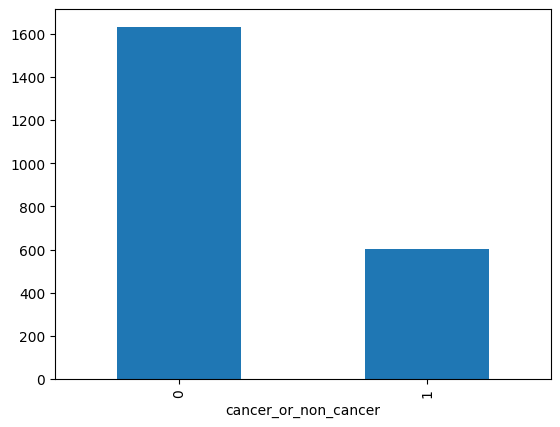

In [35]:
data[target_column].value_counts().plot(kind='bar')

In [36]:
# Handle class imbalance using SMOTE
X = data.drop(columns=[target_column])
y = data[target_column]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


Class distribution after SMOTE:
cancer_or_non_cancer
1    1633
0    1633
Name: count, dtype: int64


<Axes: xlabel='cancer_or_non_cancer'>

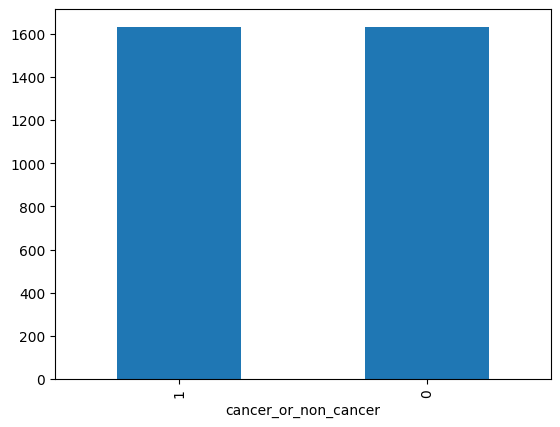

In [38]:
 pd.Series(y_resampled).value_counts().plot(kind='bar')

In [39]:
#Standard Scaling and Encoding
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [40]:
# Apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

X_processed = preprocessor.fit_transform(X_resampled)

**Correlation Analysis**

In [15]:
print("\nCorrelation Analysis:")
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['cancer_or_non_cancer'].sort_values(ascending=False)
print(correlation_with_target)


Correlation Analysis:
cancer_or_non_cancer    1.000000
localization            0.068836
skin_color              0.017312
gender                  0.014332
sun_exposure            0.009561
alcohol_consumption     0.008785
tobacco_use            -0.005747
larger_size            -0.010883
lesion_id              -0.016488
symptoms               -0.017392
age_group              -0.041309
patient_id             -0.043370
public_id              -0.174845
Name: cancer_or_non_cancer, dtype: float64


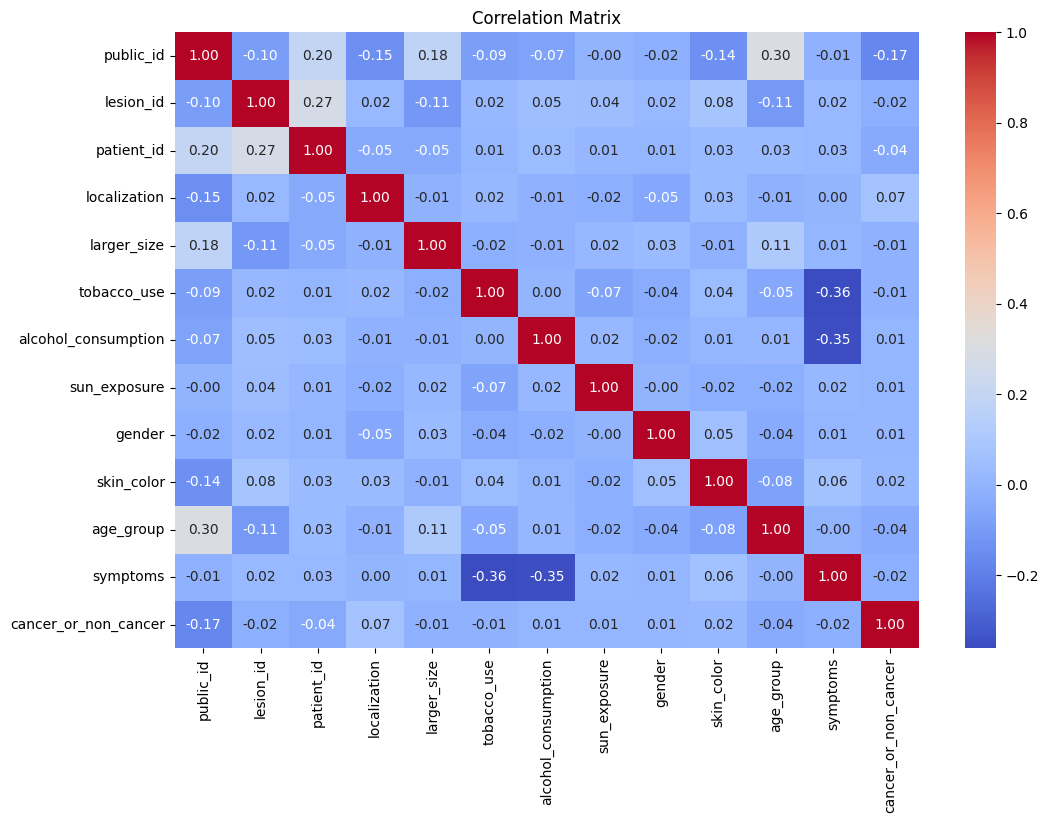

In [16]:
# Visualize correlation with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [49]:
#Feature Selection and Correlation Analysis
# Remove unnecessary features based on correlation and domain knowledge
columns_to_drop = ['patient_id', 'public_id', 'lesion_id']  # Irrelevant for prediction
print(f"\nDropping columns: {columns_to_drop}")
data = data.drop(columns=columns_to_drop)


Dropping columns: ['patient_id', 'public_id', 'lesion_id']


In [50]:
# Drop low-correlation features with domain knowledge consideration
low_correlation_features = ['skin_color', 'symptoms']
data = data.drop(columns=low_correlation_features)
print(f"\nRemaining columns after feature selection: {list(data.columns)}")


Remaining columns after feature selection: ['localization', 'larger_size', 'tobacco_use', 'alcohol_consumption', 'sun_exposure', 'gender', 'age_group', 'cancer_or_non_cancer']


In [51]:
#Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [52]:
print("\nData splitting completed:")
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Data splitting completed:
Training set: (2612, 12), Test set: (654, 12)


In [53]:
# SVM Model Training
print("\nTraining Support Vector Machine...")
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)
svm_y_prob = svm_model.predict_proba(X_test)[:, 1]


Training Support Vector Machine...


In [54]:
print("\nSupport Vector Machine Classification Report:")
print(classification_report(y_test, svm_y_pred))
print(f"Support Vector Machine ROC-AUC Score: {roc_auc_score(y_test, svm_y_prob):.2f}")


Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       327
           1       0.86      0.80      0.82       327

    accuracy                           0.83       654
   macro avg       0.83      0.83      0.83       654
weighted avg       0.83      0.83      0.83       654

Support Vector Machine ROC-AUC Score: 0.89


In [55]:
#Train Neural Network Model
nn_model = MLPClassifier(random_state=42, max_iter=1000)
print("\nTraining Neural Network model...")
nn_model.fit(X_train, y_train)


Training Neural Network model...


MLPClassifier(max_iter=1000, random_state=42)

In [56]:
# Evaluate Neural Network Model
y_pred_nn = nn_model.predict(X_test)
y_prob_nn = nn_model.predict_proba(X_test)[:, 1]

In [48]:
print("\nNeural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))
print(f"Neural Network ROC-AUC Score: {roc_auc_score(y_test, y_prob_nn):.2f}")


Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       327
           1       0.91      0.91      0.91       327

    accuracy                           0.91       654
   macro avg       0.91      0.91      0.91       654
weighted avg       0.91      0.91      0.91       654

Neural Network ROC-AUC Score: 0.98
